# Analyzing Feature Usage

In this notebook we'll use Certifai to generate counterfactual explanations of two models' predictions for a given
dataset.  By construction these will be data points optimized to be close to the model's decision boundary under
a normalizing constraint of sparsity in changed features over the corresponding original data points.

We will then analyze these counterfactual differences to obtain a frequency of occurrence of each feature in them,
which is plotted as a histogram for each of two comparative models built on the same dataset.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiFeatureRestriction)

In [2]:
# special import - 
# for multiprocessing to work in a Notebook,  pickled classes must be in a separate package or notebook
# hence, the encoder class has to be somewhere other than the current notebook
# from ipynb.fs.defs.cat_encoder import CatEncoder # <- doesn't work on Azure Notebooks
# %run cat_encoder.py # <- doesn't work because code doesn't remain external

# Azure Notebooks workaround - 
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('.')))
from cat_encoder import CatEncoder

In [3]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

# Fit a classification models (note - no train/test split here currently as I'm just using the same data as
# the scan will)
logistic_model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=1000)
logistic_model.fit(encoder(X_train.values), y_train.values)
dtree_model = DecisionTreeClassifier()
dtree_model.fit(encoder(X_train.values), y_train.values)

# Assess on the test set
logistic_accuracy = logistic_model.score(encoder(X_test.values), y_test.values)
print(f"Logistic classifier model accuracy on test data is {logistic_accuracy}")
dtree_accuracy = dtree_model.score(encoder(X_test.values), y_test.values)
print(f"Decision tree model accuracy on test data is {dtree_accuracy}")

Logistic classifier model accuracy on test data is 0.76
Decision tree model accuracy on test data is 0.635


In [4]:
# Wrap the model up for use by Certifai as a local model
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)
dtree_model_proxy = CertifaiPredictorWrapper(dtree_model, encoder=encoder)

In [5]:
# Create a scan to extract counterfactual explanations of the model predictions and build
# a histogram of the feature usage in those counterfactuals

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)
# Add our local models
first_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('dtree',
                            local_predictor=dtree_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

# don't allow changes to the nationality status
scan.add_feature_restriction('foreign', CertifaiFeatureRestriction.constant())

# Setup an evaluation for explanation on the above dataset using the model
scan.add_evaluation_type('explanation')
scan.evaluation_dataset_id = 'evaluation'
# For this analysis we'll generate explanations for the entire dataset so we have a good number
# on which to base statistical measures
scan.explanation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)


2020-05-20 17:34:47,012 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-05-20 17:34:47,015 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-05-20 17:34:47,024 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-05-20 17:34:47,027 root   WARNING  Using fallback implementation of: median_absolute_deviation


Starting scan with model_use_case_id: 'test_user_case' and scan_id: '7152f2b16550'
[--------------------] 2020-05-20 17:34:47.043914 - 0 of 2 reports (0.0% complete) - Running explanation evaluation for model: logistic
[##########----------] 2020-05-20 17:46:55.296449 - 1 of 2 reports (50.0% complete) - Running explanation evaluation for model: dtree
[####################] 2020-05-20 17:54:28.790823 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [6]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible

# Here we'll extract the frequency of feature usage in generated counterfactuals for each model
def get_feature_frequency(model_id):
    # Extract the information for fairness of a particular model id
    local_model_explanation_info = result['explanation'][model_id]
    # Extract the full set of counterfactuals for this
    all_counterfactuals = [ind for r in local_model_explanation_info['explanations'] for ind in r['bestIndividuals']]

    def features_changed(counterfactual):
        # Each feature has an entry saying how it changed.  This will be one of:
        #   'unchanged'
        #   'changed' (categorical change)
        #   <numeric> (differnce from original value for numeric feaure)
        def no_change(diff):
            return (diff == 'unchanged') or diff == 0

        diffs = counterfactual['diff']
        return [idx for idx in range(len(diffs)) if not no_change(diffs[idx])]


    # Get the full list of model features from the schema
    features = local_model_explanation_info['model_schema']['feature_schemas']
    num_model_features = len(features)

    feature_names = np.array([f['name'] for f in features])
    
    # Count the changes for each feature across the dataset
    all_changes = np.zeros(num_model_features)
    for cf in all_counterfactuals:
        changed = features_changed(cf)
        for idx in changed:
            all_changes[idx] += 1
    return all_changes, feature_names

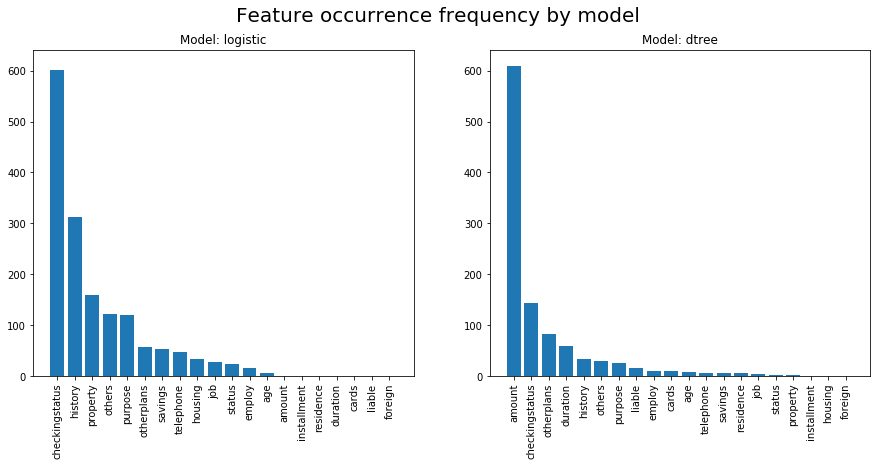

In [7]:
# Plot a histogram of frequency of occurrence of changes to each feature in counterfactuals
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(ax, model_id):
    all_changes, feature_names = get_feature_frequency(model_id)
    indexes = np.arange(len(all_changes))
    order = np.argsort(-all_changes)

    ax.bar(indexes,all_changes[order])

    ax.ylabel = 'Frequency'
    ax.set_title(f'Model: {model_id}')
    ax.set_xticks(indexes)
    ax.set_xticklabels(feature_names[order], rotation=90)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])
fig.suptitle('Feature occurrence frequency by model', fontsize=20)

plot_histogram(ax1, 'logistic')
plot_histogram(ax2, 'dtree')

# Put them both on the same scale
ylim = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(top=ylim)
ax2.set_ylim(top=ylim)

plt.show()